# Synthetic Concrete Crack Generation with a Variational Autoencoder (VAE)

## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Dataset and Data Loader Classes

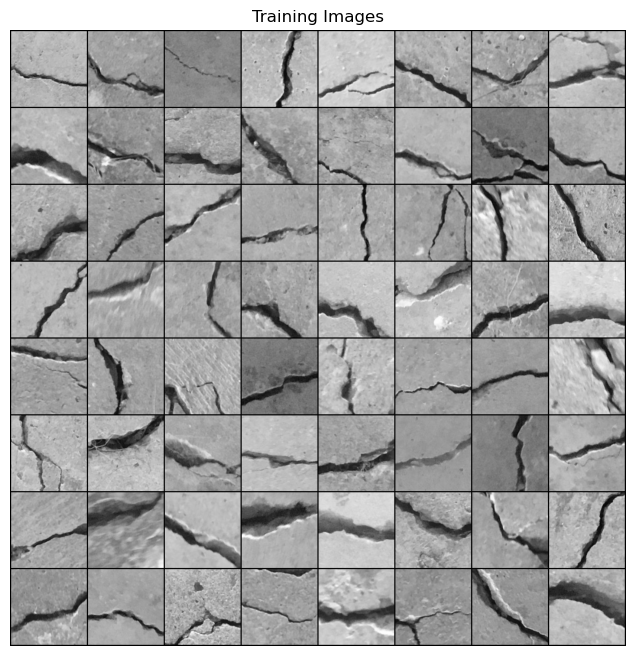

In [2]:
class CrackDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = Path(root_dir)
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.root_dir / self.image_files[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

#####Parameters
IMG_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 100

#Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


dataset_path = 'processed_images'

dataset = CrackDataset(root_dir = dataset_path, transform = transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)


real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch.to(device)[:64], padding = 2, normalize = True).cpu(),(1,2,0)))
plt.show()

## VAE Model Class

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 4, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 4, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 256, 8, 8)
        return self.decoder(result)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Loss Function

In [4]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, IMG_SIZE*IMG_SIZE), x.view(-1, IMG_SIZE*IMG_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## Model Training

In [ ]:
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
NUM_EPOCHS = 50 

for epoch in range(NUM_EPOCHS):
    loop = tqdm(dataloader, desc = f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    total_loss = 0
    for data in loop:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta=0.5) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        loop.set_postfix(loss=loss.item() / len(data))
    
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch: {epoch+1} Average loss: {avg_loss:.4f}')

print("Training complete.")

Epoch [1/100]: 100%|██████████| 313/313 [00:33<00:00,  9.28it/s, loss=1.02e+4]


Epoch: 1 Average loss: 10376.7600


Epoch [2/100]: 100%|██████████| 313/313 [00:30<00:00, 10.32it/s, loss=9.95e+3]


Epoch: 2 Average loss: 10162.5796


Epoch [3/100]: 100%|██████████| 313/313 [00:29<00:00, 10.47it/s, loss=1.02e+4]


Epoch: 3 Average loss: 10130.3990


Epoch [4/100]: 100%|██████████| 313/313 [00:30<00:00, 10.39it/s, loss=1.01e+4]


Epoch: 4 Average loss: 10117.1166


Epoch [5/100]: 100%|██████████| 313/313 [00:29<00:00, 10.74it/s, loss=1e+4]   


Epoch: 5 Average loss: 10109.4646


Epoch [6/100]: 100%|██████████| 313/313 [00:27<00:00, 11.26it/s, loss=1.03e+4]


Epoch: 6 Average loss: 10104.9447


Epoch [7/100]: 100%|██████████| 313/313 [00:22<00:00, 14.17it/s, loss=1e+4]   


Epoch: 7 Average loss: 10102.3980


Epoch [8/100]: 100%|██████████| 313/313 [00:20<00:00, 15.32it/s, loss=1.01e+4]


Epoch: 8 Average loss: 10098.9743


Epoch [9/100]: 100%|██████████| 313/313 [00:18<00:00, 16.50it/s, loss=1.01e+4]


Epoch: 9 Average loss: 10096.7187


Epoch [10/100]: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, loss=1.02e+4]


Epoch: 10 Average loss: 10095.3095


Epoch [11/100]: 100%|██████████| 313/313 [00:18<00:00, 17.09it/s, loss=1.03e+4]


Epoch: 11 Average loss: 10094.6080


Epoch [12/100]: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, loss=1.01e+4]


Epoch: 12 Average loss: 10091.8243


Epoch [13/100]: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, loss=1.02e+4]


Epoch: 13 Average loss: 10090.1161


Epoch [14/100]: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, loss=1.01e+4]


Epoch: 14 Average loss: 10089.2159


Epoch [15/100]: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, loss=9.9e+3] 


Epoch: 15 Average loss: 10087.9463


Epoch [16/100]: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, loss=1.03e+4]


Epoch: 16 Average loss: 10087.1490


Epoch [17/100]: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, loss=1.01e+4]


Epoch: 17 Average loss: 10085.5448


Epoch [18/100]: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, loss=1.01e+4]


Epoch: 18 Average loss: 10085.2258


Epoch [19/100]: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, loss=1.01e+4]


Epoch: 19 Average loss: 10083.6473


Epoch [20/100]: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, loss=9.97e+3]


Epoch: 20 Average loss: 10082.9201


Epoch [21/100]: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, loss=1.02e+4]


Epoch: 21 Average loss: 10082.0736


Epoch [22/100]: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, loss=1.03e+4]


Epoch: 22 Average loss: 10081.4777


Epoch [23/100]: 100%|██████████| 313/313 [00:17<00:00, 17.47it/s, loss=1.02e+4]


Epoch: 23 Average loss: 10080.4787


Epoch [24/100]: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, loss=9.99e+3]


Epoch: 24 Average loss: 10079.5079


Epoch [25/100]: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, loss=1.03e+4]


Epoch: 25 Average loss: 10079.0054


Epoch [26/100]: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, loss=9.94e+3]


Epoch: 26 Average loss: 10078.4781


Epoch [27/100]: 100%|██████████| 313/313 [00:17<00:00, 17.46it/s, loss=1e+4]   


Epoch: 27 Average loss: 10077.7307


Epoch [28/100]: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, loss=1e+4]   


Epoch: 28 Average loss: 10076.9192


Epoch [29/100]: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, loss=1.02e+4]


Epoch: 29 Average loss: 10076.3189


Epoch [30/100]: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, loss=1e+4]   


Epoch: 30 Average loss: 10075.8137


Epoch [31/100]: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, loss=9.95e+3]


Epoch: 31 Average loss: 10075.1832


Epoch [32/100]: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, loss=1.01e+4]


Epoch: 32 Average loss: 10074.6539


Epoch [33/100]: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, loss=1e+4]   


Epoch: 33 Average loss: 10074.4300


Epoch [34/100]: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, loss=1.01e+4]


Epoch: 34 Average loss: 10074.0564


Epoch [35/100]: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, loss=1e+4]   


Epoch: 35 Average loss: 10073.1503


Epoch [36/100]: 100%|██████████| 313/313 [00:17<00:00, 18.00it/s, loss=1.02e+4]


Epoch: 36 Average loss: 10072.5593


Epoch [37/100]: 100%|██████████| 313/313 [00:17<00:00, 18.04it/s, loss=1.03e+4]


Epoch: 37 Average loss: 10072.3428


Epoch [38/100]: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, loss=1.02e+4]


Epoch: 38 Average loss: 10072.0462


Epoch [39/100]: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, loss=1e+4]   


Epoch: 39 Average loss: 10071.3945


Epoch [40/100]: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, loss=1.03e+4]


Epoch: 40 Average loss: 10070.7986


Epoch [41/100]: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, loss=9.84e+3]


Epoch: 41 Average loss: 10070.6841


Epoch [42/100]: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, loss=1.01e+4]


Epoch: 42 Average loss: 10070.8972


Epoch [43/100]: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, loss=1.02e+4]


Epoch: 43 Average loss: 10070.0166


Epoch [44/100]: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, loss=1.02e+4]


Epoch: 44 Average loss: 10069.8875


Epoch [45/100]: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, loss=1.01e+4]


Epoch: 45 Average loss: 10069.5373


Epoch [46/100]: 100%|██████████| 313/313 [00:17<00:00, 18.01it/s, loss=1.02e+4]


Epoch: 46 Average loss: 10068.7617


Epoch [47/100]: 100%|██████████| 313/313 [00:17<00:00, 17.97it/s, loss=9.95e+3]


Epoch: 47 Average loss: 10068.8022


Epoch [48/100]: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, loss=1.02e+4]


Epoch: 48 Average loss: 10068.5418


Epoch [49/100]: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, loss=1.01e+4]


Epoch: 49 Average loss: 10068.3300


Epoch [50/100]: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, loss=1e+4]   


Epoch: 50 Average loss: 10067.8082


Epoch [51/100]: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, loss=1.01e+4]


Epoch: 51 Average loss: 10067.4267


Epoch [52/100]: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, loss=9.98e+3]


Epoch: 52 Average loss: 10067.2667


Epoch [53/100]: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, loss=1.01e+4]


Epoch: 53 Average loss: 10067.1507


Epoch [54/100]: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, loss=1e+4]   


Epoch: 54 Average loss: 10066.6423


Epoch [55/100]: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, loss=1.02e+4]


Epoch: 55 Average loss: 10066.4664


Epoch [56/100]: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, loss=9.79e+3]


Epoch: 56 Average loss: 10066.5032


Epoch [57/100]: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, loss=1.01e+4]


Epoch: 57 Average loss: 10065.9853


Epoch [58/100]: 100%|██████████| 313/313 [00:17<00:00, 17.49it/s, loss=1.01e+4]


Epoch: 58 Average loss: 10065.8560


Epoch [59/100]: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, loss=1e+4]   


Epoch: 59 Average loss: 10065.8816


Epoch [60/100]: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, loss=9.87e+3]


Epoch: 60 Average loss: 10065.3608


Epoch [61/100]: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, loss=1.02e+4]


Epoch: 61 Average loss: 10065.0419


Epoch [62/100]: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, loss=1.01e+4]


Epoch: 62 Average loss: 10065.4171


Epoch [63/100]: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, loss=1.02e+4]


Epoch: 63 Average loss: 10064.6207


Epoch [64/100]: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, loss=1.02e+4]


Epoch: 64 Average loss: 10064.8880


Epoch [65/100]: 100%|██████████| 313/313 [00:17<00:00, 17.75it/s, loss=1.01e+4]


Epoch: 65 Average loss: 10064.2282


Epoch [66/100]: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, loss=1.01e+4]


Epoch: 66 Average loss: 10064.2029


Epoch [67/100]: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, loss=1.02e+4]


Epoch: 67 Average loss: 10063.8566


Epoch [68/100]: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, loss=1e+4]   


Epoch: 68 Average loss: 10063.7147


Epoch [69/100]: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, loss=1.03e+4]


Epoch: 69 Average loss: 10063.8756


Epoch [70/100]: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, loss=1.02e+4]


Epoch: 70 Average loss: 10063.5388


Epoch [71/100]: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, loss=1.01e+4]


Epoch: 71 Average loss: 10063.3120


Epoch [72/100]: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, loss=9.91e+3]


Epoch: 72 Average loss: 10063.1400


Epoch [73/100]: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, loss=9.97e+3]


Epoch: 73 Average loss: 10062.9107


Epoch [74/100]: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, loss=1.01e+4]


Epoch: 74 Average loss: 10062.9589


Epoch [75/100]: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, loss=9.84e+3]


Epoch: 75 Average loss: 10062.7523


Epoch [76/100]: 100%|██████████| 313/313 [00:17<00:00, 17.91it/s, loss=9.89e+3]


Epoch: 76 Average loss: 10062.6402


Epoch [77/100]: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, loss=1.01e+4]


Epoch: 77 Average loss: 10062.3358


Epoch [78/100]: 100%|██████████| 313/313 [00:18<00:00, 17.05it/s, loss=1.03e+4]


Epoch: 78 Average loss: 10062.1040


Epoch [79/100]: 100%|██████████| 313/313 [00:18<00:00, 17.03it/s, loss=9.88e+3]


Epoch: 79 Average loss: 10061.9851


Epoch [80/100]: 100%|██████████| 313/313 [00:18<00:00, 17.15it/s, loss=1.02e+4]


Epoch: 80 Average loss: 10061.9093


Epoch [81/100]: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, loss=1.01e+4]


Epoch: 81 Average loss: 10061.8435


Epoch [82/100]: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, loss=1e+4]   


Epoch: 82 Average loss: 10061.8647


Epoch [83/100]: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, loss=1.02e+4]


Epoch: 83 Average loss: 10061.4100


Epoch [84/100]: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, loss=1e+4]   


Epoch: 84 Average loss: 10061.4768


Epoch [85/100]: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, loss=9.88e+3]


Epoch: 85 Average loss: 10061.2630


Epoch [86/100]: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, loss=9.98e+3]


Epoch: 86 Average loss: 10061.0761


Epoch [87/100]: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, loss=1.01e+4]


Epoch: 87 Average loss: 10061.0045


Epoch [88/100]: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, loss=1.01e+4]


Epoch: 88 Average loss: 10060.7797


Epoch [89/100]: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, loss=9.95e+3]


Epoch: 89 Average loss: 10060.7845


Epoch [90/100]: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, loss=9.97e+3]


Epoch: 90 Average loss: 10060.8999


Epoch [91/100]: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, loss=1.01e+4]


Epoch: 91 Average loss: 10060.4261


Epoch [92/100]: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, loss=1.02e+4]


Epoch: 92 Average loss: 10060.2596


Epoch [93/100]: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, loss=1.02e+4]


Epoch: 93 Average loss: 10060.2827


Epoch [94/100]: 100%|██████████| 313/313 [00:17<00:00, 17.47it/s, loss=9.85e+3]


Epoch: 94 Average loss: 10060.2304


Epoch [95/100]: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, loss=1.03e+4]


Epoch: 95 Average loss: 10059.9868


Epoch [96/100]: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, loss=9.78e+3]


Epoch: 96 Average loss: 10059.9374


Epoch [97/100]: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, loss=1e+4]   


Epoch: 97 Average loss: 10059.7064


Epoch [98/100]: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, loss=1.01e+4]


Epoch: 98 Average loss: 10059.7069


Epoch [99/100]: 100%|██████████| 313/313 [00:17<00:00, 17.46it/s, loss=9.98e+3]


Epoch: 99 Average loss: 10059.5684


Epoch [100/100]: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, loss=9.96e+3]

Epoch: 100 Average loss: 10059.4072
Training complete.


# Saving Trained Model

In [6]:
MODEL_PATH = 'vae_crack_generator.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to vae_crack_generator.pth


# Loading the Model

In [7]:
model = VAE(latent_dim=LATENT_DIM).to(device)
MODEL_PATH = 'vae_crack_generator.pth'
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

## Model Evaluation

Top Row: Real Images, Bottom Row: Reconstructed Images


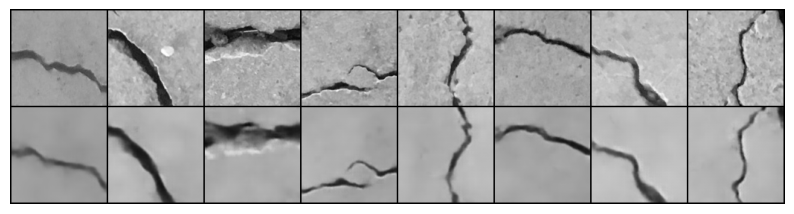

In [8]:
model.eval()
with torch.no_grad():
    real_images = next(iter(dataloader)).to(device)
    reconstructed_images, _, _ = model(real_images)

    comparison = torch.cat([real_images[:8], reconstructed_images.view(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE)[:8]])
    grid = make_grid(comparison, nrow=8, padding=2, normalize=True)
    
    print("Top Row: Real Images, Bottom Row: Reconstructed Images")
    plt.figure(figsize=(10, 3))
    plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.savefig('vae_reconstruction_comparison.png')
    plt.show()

## Image Generation


Generated Synthetic Crack Images


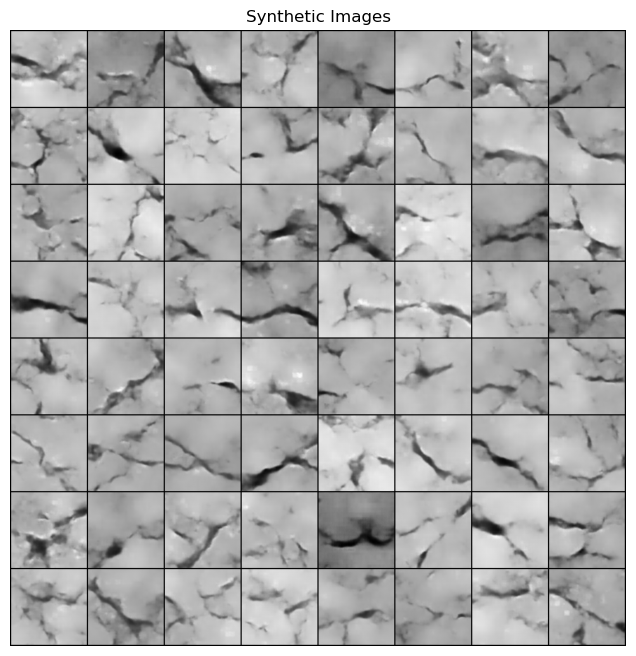

In [9]:
with torch.no_grad():
    z = torch.randn(64, LATENT_DIM).to(device)
    generated_images = model.decode(z).cpu()
    
    print("\nGenerated Synthetic Crack Images")
    grid = make_grid(generated_images, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Synthetic Images")
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.savefig('synthetic_crack_images.png')
    plt.show()